# Libraries

In [ ]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import exists
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the Files

Download the csv files into the `data/` directory.

In [47]:
trainingSet = pd.read_csv("./drive/MyDrive/train.csv")
testingSet = pd.read_csv("./drive/MyDrive/test.csv")


X_submission = pd.merge(testingSet, trainingSet, on='Id', how='left')

SubtrainingSet = trainingSet.sample(frac=0.05)





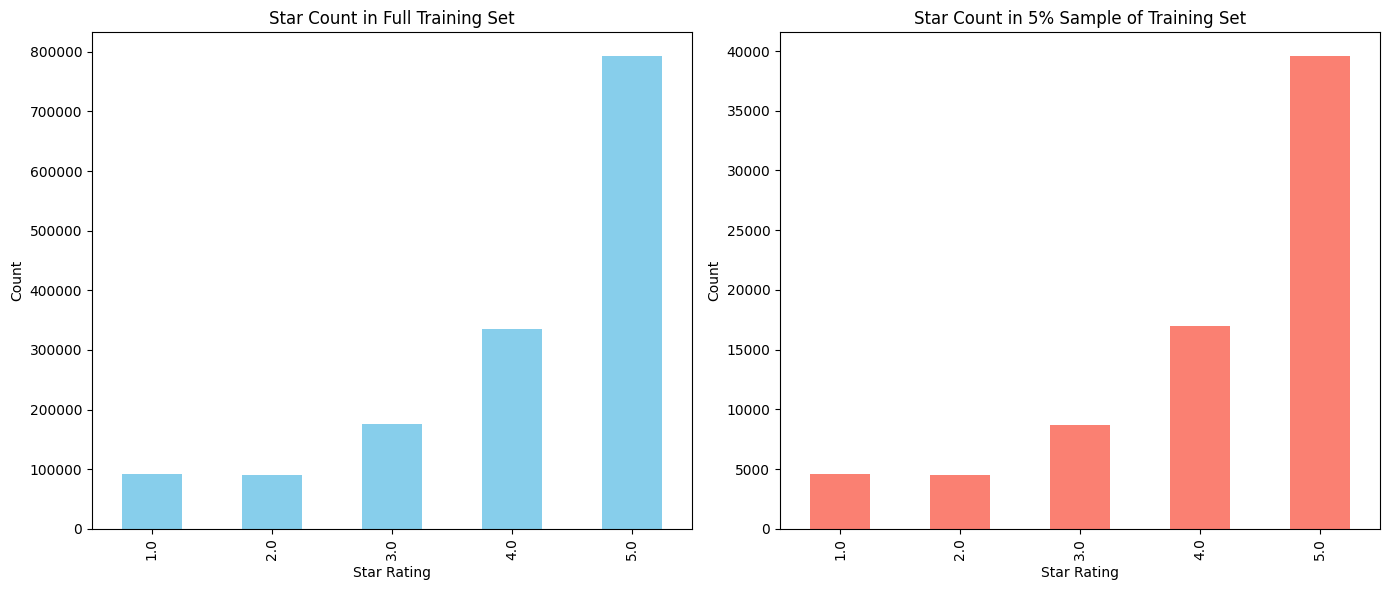

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

trainingSet['Score'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("Star Count in Full Training Set")
axes[0].set_xlabel("Star Rating")
axes[0].set_ylabel("Count")

SubtrainingSet['Score'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title("Star Count in 5% Sample of Training Set")
axes[1].set_xlabel("Star Rating")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Adding Features

In [49]:


def word_count(text):
    if isinstance(text, str):
        return len(text.split())
    else:
        return 0



def add_features_to(df):
    # This is where you can do all your feature extraction
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    df['ReviewLength'] = df['Text'].apply(word_count)
    df['ReviewLength'] = df['ReviewLength'].fillna(0)
    df['Text'] = df['Text'].fillna('missing')
    df['Summary'] = df['Summary'].fillna('missing')
    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df['Year'] = df['Time'].dt.year
    df['Month'] = df['Time'].dt.month
    df['Day'] = df['Time'].dt.day
    df['DayOfWeek'] = df['Time'].dt.dayofweek
    df['Hour'] = df['Time'].dt.hour


    vectorizer = TfidfVectorizer(max_features=100 , ngram_range=(1, 5))
    X_text = vectorizer.fit_transform(df['Text']).toarray()
    X_text_df = pd.DataFrame(X_text, columns=[f'tfidf_{i}' for i in range(X_text.shape[1])], index=df.index)
    df_combined = pd.concat([df, X_text_df], axis=1)

    summary_vec = TfidfVectorizer(max_features= 20 , ngram_range=(1, 5))
    X_summary = summary_vec.fit_transform(df['Summary']).toarray()
    X_summary_df = pd.DataFrame(X_summary, columns=[f'tfidf_{i}' for i in range(500, 500 + X_summary.shape[1])], index=df.index)
    df_combined = pd.concat([df_combined, X_summary_df], axis=1)
    return df_combined
# Load the feature extracted files if they've already been generated
if exists('./drive/MyDrive/X_train11.csv'):
    X_train = pd.read_csv("./drive/MyDrive/X_train11.csv")

else:
    train = add_features_to(SubtrainingSet)
    print(train.shape)
    X_train =  train[train['Score'].notnull()]
    X_train.to_csv("./drive/MyDrive/X_train11.csv", index=False)

(84877, 136)


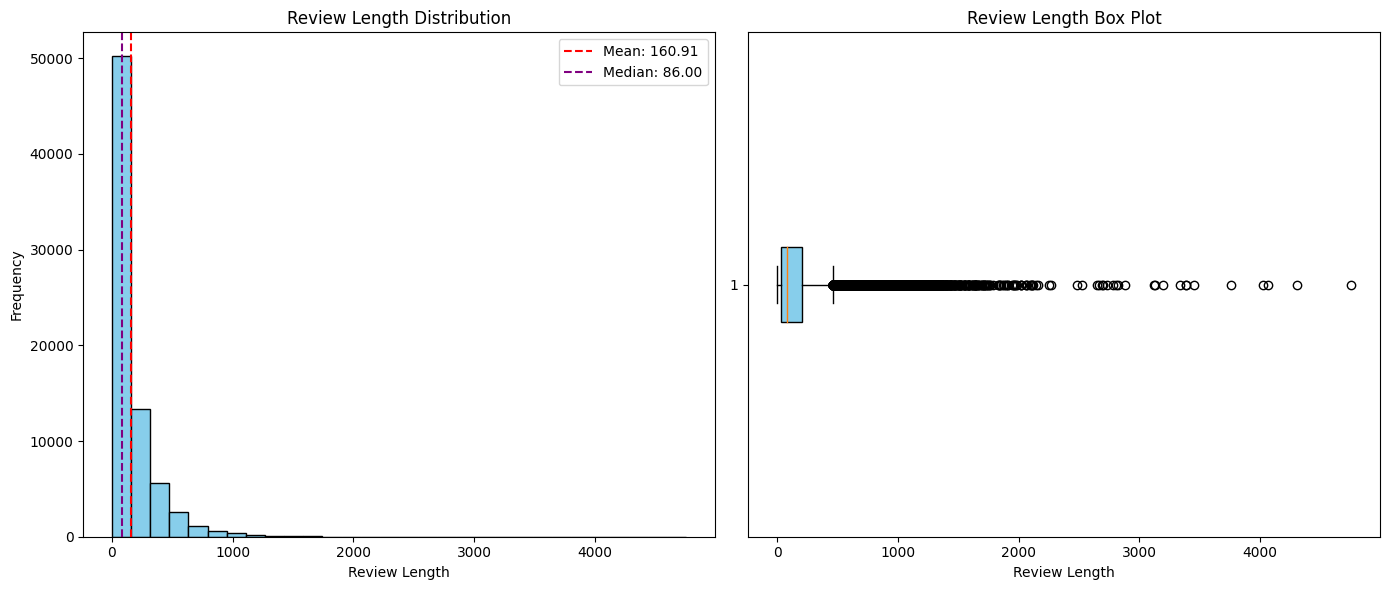

In [50]:
mean_length = X_train['ReviewLength'].mean()
median_length = X_train['ReviewLength'].median()
std_length = X_train['ReviewLength'].std()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(X_train['ReviewLength'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='purple', linestyle='--', label=f'Median: {median_length:.2f}')
plt.title('Review Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(X_train['ReviewLength'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.title('Review Length Box Plot')
plt.xlabel('Review Length')

plt.tight_layout()
plt.show()

# Sample + Split into training and testing set

In [51]:

Y_train = X_train['Score']
Y_train_true = X_train['Score']
X_train = X_train.drop(columns=['Score'])

# Feature Selection

In [52]:
X_train_select = X_train.drop(columns=['ProductId' , 'UserId' , 'Summary' ,'Text' , 'Id' , 'Time' ])
print(X_train_select.shape)
print(X_train_select.dtypes)

(74252, 129)
HelpfulnessNumerator        int64
HelpfulnessDenominator      int64
Helpfulness               float64
ReviewLength                int64
Year                        int32
                           ...   
tfidf_515                 float64
tfidf_516                 float64
tfidf_517                 float64
tfidf_518                 float64
tfidf_519                 float64
Length: 129, dtype: object


In [54]:

import lightgbm as lgb

importance_values = []

lgbm = lgb.LGBMClassifier(objective='multiclass', num_class=5)


lgbm.fit(X_train_select, Y_train)
importance = lgbm.feature_importances_
feature_names = X_train_select.columns
sorted_features = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_features:
    print(f"Feature: {feature}, Importance: {importance}")
    importance_values.append(importance)




cumulative_importance = np.cumsum(importance_values)

cumulative_importance_percentage = cumulative_importance / np.sum(importance_values) * 100

num_features_90 = np.argmax(cumulative_importance_percentage >= 90) + 1
num_features_95 = np.argmax(cumulative_importance_percentage >= 95) + 1

print(f"Number of features that contribute to 85% of importance: {num_features_90}")
print(f"Number of features that contribute to 95% of importance: {num_features_95}")

top_features = [f[0] for f in sorted_features[:num_features_90]]
X_train_reduced = X_train_select[top_features]




Feature: HelpfulnessDenominator, Importance: 518
Feature: Helpfulness, Importance: 411
Feature: tfidf_11, Importance: 332
Feature: tfidf_52, Importance: 313
Feature: tfidf_78, Importance: 303
Feature: tfidf_24, Importance: 289
Feature: tfidf_4, Importance: 284
Feature: tfidf_87, Importance: 265
Feature: Year, Importance: 250
Feature: tfidf_71, Importance: 208
Feature: tfidf_41, Importance: 201
Feature: ReviewLength, Importance: 197
Feature: tfidf_512, Importance: 194
Feature: tfidf_51, Importance: 191
Feature: tfidf_23, Importance: 189
Feature: tfidf_67, Importance: 181
Feature: tfidf_99, Importance: 175
Feature: tfidf_59, Importance: 170
Feature: tfidf_16, Importance: 165
Feature: tfidf_89, Importance: 165
Feature: tfidf_506, Importance: 165
Feature: tfidf_82, Importance: 162
Feature: tfidf_47, Importance: 161
Feature: tfidf_53, Importance: 160
Feature: tfidf_43, Importance: 158
Feature: tfidf_1, Importance: 157
Feature: tfidf_50, Importance: 154
Feature: tfidf_39, Importance: 152
Fea

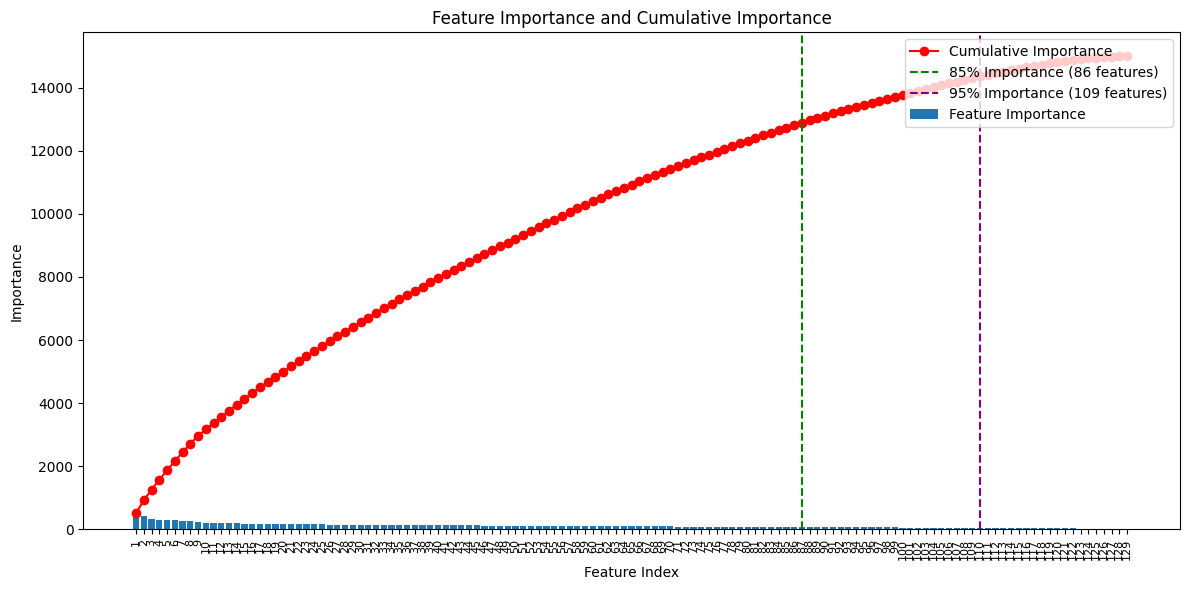

In [55]:

feature_names_sorted = [f[0] for f in sorted_features]
importance_values_sorted = [f[1] for f in sorted_features]
plt.figure(figsize=(12, 6))
plt.bar(range(len(importance_values_sorted)), importance_values_sorted, label='Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.xticks(range(len(importance_values_sorted)), range(1, len(importance_values_sorted) + 1), rotation=90, fontsize=8)
plt.title('Feature Importance and Cumulative Importance')

plt.plot(range(len(importance_values_sorted)), cumulative_importance, color='r', label='Cumulative Importance', marker='o')
plt.axvline(num_features_85, color='g', linestyle='--', label=f'85% Importance ({num_features_85} features)')
plt.axvline(num_features_95, color='purple', linestyle='--', label=f'95% Importance ({num_features_95} features)')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Model Creation

In [56]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC # Import SVM classifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

class XGBoostWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.model = XGBClassifier(**kwargs)

    def fit(self, X, y):
        y_adjusted = y
        self.model.fit(X, y_adjusted)

    def predict(self, X):
        predictions = self.model.predict(X)
        return predictions

lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=5,
    num_leaves=30,
    learning_rate=0.005,
    n_estimators=3000,
    max_depth=4,
    lambda_l1=1.0,
    lambda_l2=1.0,
    n_jobs=-1,
    verbose=-1
)

rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=25,
    min_samples_split=15,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
xgb_model = XGBoostWrapper(
    colsample_bytree=0.6,
    gamma=0,
    learning_rate=0.005,
    max_depth=5,
    n_estimators=3000,
    scale_pos_weight=1,
    objective='multi:softmax',
    num_class=5,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

stacking_model = StackingClassifier(
    estimators=[
        ('lightgbm', lgb_model),
        ('random_forest', rf_model),
        ('xgboost', xgb_model),
    ],
    final_estimator=LogisticRegression(C=0.1, max_iter=100),
    cv=5
)

Y_train_true = Y_train_true.astype(int)

stacking_model.fit(X_train_reduced, Y_train_true)

Y_train_pred = stacking_model.predict(X_train_reduced)
train_accuracy = accuracy_score(Y_train_true, Y_train_pred)
print("Stacking Model Training Accuracy:", train_accuracy)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking Model Training Accuracy: 0.6876582448957603


## Testing

In [57]:
testingSet = pd.read_csv("./drive/MyDrive/train.csv")
testingSet = testingSet.sample(frac=0.05)

test = add_features_to(testingSet)
X_test =  test[test['Score'].notnull()]

Y_test = X_test['Score']
Y_test_true = X_test['Score']
X_test = X_test.drop(columns=['Score'])
X_test_select = X_test.drop(columns=['ProductId' , 'UserId' , 'Summary' ,'Text' , 'Id' , 'Time' ])
X_test_reduced = X_test_select[top_features]

Y_test_pred = stacking_model.predict(X_test_reduced)
test_accuracy = accuracy_score(Y_test_true, Y_test_pred)
print(test_accuracy)


0.5956036851462745


In [58]:
from collections import Counter

true_counts = Counter(Y_train_true)
predicted_counts = Counter(Y_train_pred)

print("True label distribution:")
for label, count in sorted(true_counts.items()):
    print(f"Star Rating {label}: {count}")

print("\nPredicted label distribution:")
for label, count in sorted(predicted_counts.items()):
    print(f"Star Rating {label}: {count}")



True label distribution:
Star Rating 1: 4546
Star Rating 2: 4488
Star Rating 3: 8700
Star Rating 4: 16933
Star Rating 5: 39585

Predicted label distribution:
Star Rating 1: 4039
Star Rating 2: 1494
Star Rating 3: 5928
Star Rating 4: 10680
Star Rating 5: 52111


ValueError: operands could not be broadcast together with shapes (74252,) (74244,) 

In [ ]:
if exists('./drive/MyDrive/X_submission_6.csv'):
    X_train = pd.read_csv("./drive/MyDrive/X_submission_6.csv")
else:
  X_submission = add_features_to(X_submission)

  X_submission = X_submission.drop(columns=['Score_x'])
  X_submission = X_submission.rename(columns={'Score_y': 'Score'})
  Y_true = X_submission['Score']
  X_submission_select = X_submission.drop(columns=['ProductId' , 'UserId' , 'Summary' ,'Text' , 'Id' ,'Time' ])
  X_submission_reduced = X_submission_select[top_features]
  X_submission_reduced.to_csv("./drive/MyDrive/X_submission_6.csv", index=False)



X_submission['Score'] = stacking_model.predict(X_submission_reduced)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./drive/MyDrive/submission6.csv", index=False)